<a href="https://colab.research.google.com/github/sharmaanix/BigQuery-Python/blob/master/notebook/RecSYS_suprise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective to do

# Scaling the weight playcount

#### 1. MinMaxScaler - Scale the weight without distortion
#### 2. RobustScaler - Better for the Outlier
#### 3. StandardScaler - to have  distribution close to normal distribution

# Mount Driver

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import required library

In [0]:
!pip install surprise

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, NormalPredictor

In [0]:
%matplotlib inline

In [0]:
cd drive/My\ Drive/lastfm_dataset

/content/drive/My Drive/lastfm_dataset


In [0]:
!ls

artists.dat  user_artists.dat	     user_taggedartists-timestamps.dat
readme.txt   user_friends.dat
tags.dat     user_taggedartists.dat


In [0]:
user_artist = pd.read_csv('user_artists.dat', sep='\t')

In [0]:
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [0]:
total_algorithm = {'SVD' : SVD(), 'SVDpp' : SVDpp(), 'KNNBaseline' : KNNBaseline(), 'KNNBasic' : KNNBasic(), 'KNNWithMeans' : KNNWithMeans(), 'KNNWithZScore' : KNNWithZScore(), 
                   'CoClustering' : CoClustering(), 'BaselineOnly' : BaselineOnly(), 'NormalPredictor' : NormalPredictor()}

In [0]:
def model_train_evaluate(total_algorithm, surprise_data, weight_type):
  for idx,algorithm in enumerate(total_algorithm):
    print(algorithm)
    result = cross_validate(total_algorithm[algorithm], surprise_data, cv=5)
    temp_df = pd.DataFrame(result.values()).T
    temp_df.columns = list(result.keys())
    temp_df['algorithm'] = algorithm

    if idx == 0:
      result_df = temp_df
    else:
      result_df = result_df.append(temp_df,ignore_index=True)

    result_df['weight_type'] = weight_type
    
  return result_df

# Suprise recommendation Engine using MinMaxScaler

In [0]:
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [0]:
SCALING_FACTOR = 10

In [0]:
minmax_scale = MinMaxScaler()

In [0]:
user_artist['minmax_scale'] = minmax_scale.fit_transform(np.array(user_artist['weight']).reshape(-1,1)).reshape(1,-1)[0]*SCALING_FACTOR

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale
0,2,51,13883,0.393596
1,2,52,11690,0.331418
2,2,53,11351,0.321806
3,2,54,10300,0.292007
4,2,55,8983,0.254666


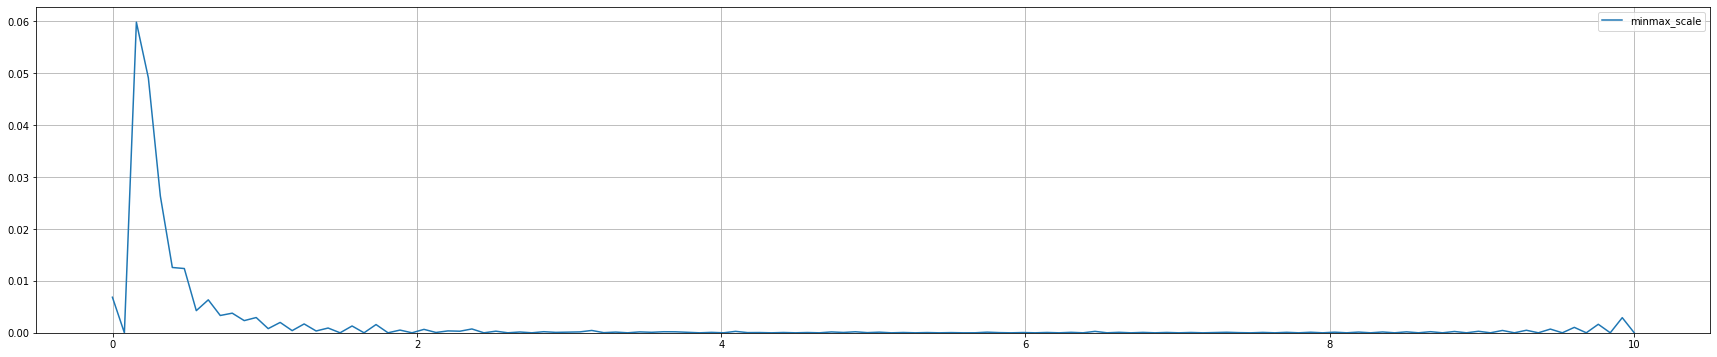

In [0]:
plt.figure(figsize=(30,6))
sns.kdeplot(user_artist['minmax_scale'])
plt.grid()

In [0]:
skew(user_artist['minmax_scale']), kurtosis(user_artist['minmax_scale'])

(43.26901867955808, 2893.5831680519423)

In [0]:
scale = user_artist['minmax_scale'].min(), user_artist['minmax_scale'].max()

In [0]:
scale

(0.0, 10.0)

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale
0,2,51,13883,0.393596
1,2,52,11690,0.331418
2,2,53,11351,0.321806
3,2,54,10300,0.292007
4,2,55,8983,0.254666


In [0]:
data_minmax = Dataset.load_from_df(user_artist.drop(columns=['weight']), reader= Reader(rating_scale= scale))

In [0]:
eval_minmax = model_train_evaluate(total_algorithm, data_minmax, 'minmax_scale')

SVD
SVDpp


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
Computin

In [0]:
eval_minmax.groupby('algorithm').mean()

,fit_time,test_mae,test_rmse,test_time
algorithm,,,,
BaselineOnly,0.132743,0.019778,0.103438,0.107462
CoClustering,2.103077,0.022677,0.118479,0.080075
KNNBaseline,0.400216,0.020023,0.103608,1.699127
KNNBasic,0.278551,0.022509,0.106072,1.349892
KNNWithMeans,0.308605,0.021789,0.104091,1.472455
KNNWithZScore,0.373103,0.020925,0.110885,1.629698
NormalPredictor,0.096028,0.059396,0.130394,0.149555
SVD,3.820886,0.043865,0.116026,0.147570
SVDpp,36.229042,0.029452,0.105667,0.781669


# Scaled Logarithmic recommendation Engine

In [0]:
user_artist['log_weight'] = np.log(user_artist['weight'])

In [0]:
skew(user_artist['log_weight']), kurtosis(user_artist['log_weight'])

(-0.5031603419793773, 1.3369565746759697)

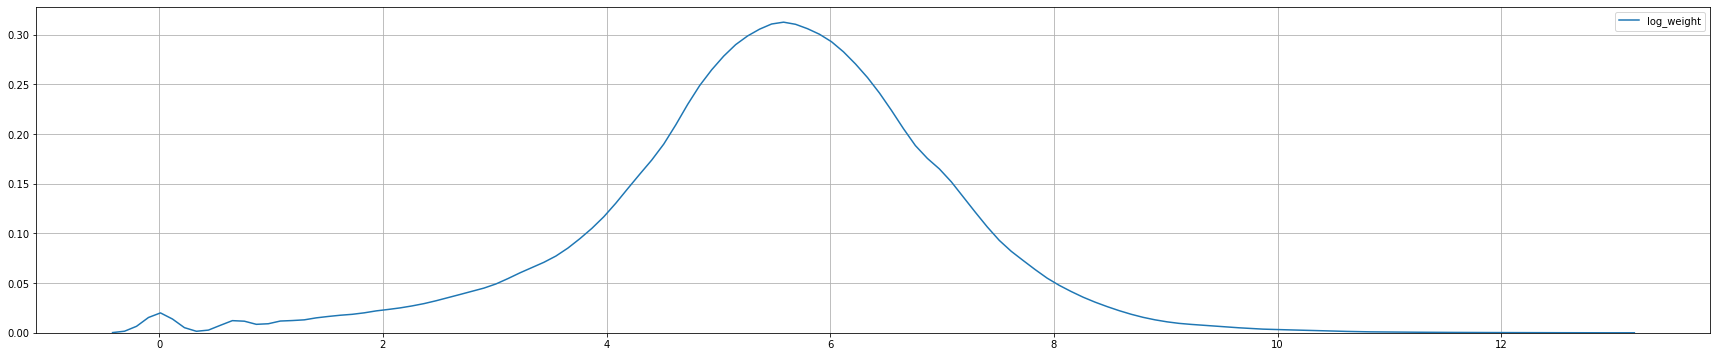

In [0]:
plt.figure(figsize=(30,6))
sns.kdeplot(user_artist['log_weight'])
plt.grid()

In [0]:
user_artist['log_minmax'] = minmax_scale.fit_transform(np.array(user_artist['log_weight']).reshape(-1,1)).reshape(1,-1)[0]*SCALING_FACTOR

In [0]:
skew(user_artist['log_minmax']), kurtosis(user_artist['log_minmax'])

(-0.5031603419793795, 1.3369565746759697)

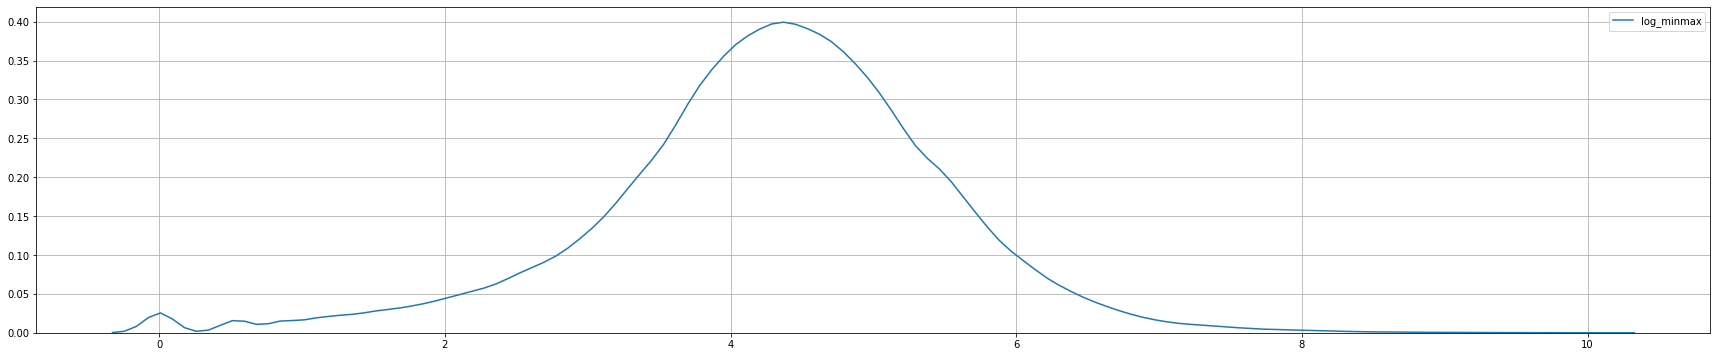

In [0]:
plt.figure(figsize=(30,6))
sns.kdeplot(user_artist['log_minmax'])
plt.grid()

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale,log_weight,log_minmax
0,2,51,13883,0.393596,9.538420,7.467428
1,2,52,11690,0.331418,9.366489,7.332827
2,2,53,11351,0.321806,9.337061,7.309788
3,2,54,10300,0.292007,9.239899,7.233722
4,2,55,8983,0.254666,9.103089,7.126617


In [0]:
scale = user_artist['log_minmax'].min(), user_artist['log_minmax'].max()

In [0]:
scale

(0.0, 9.999999999999998)

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale,log_weight,log_minmax
0,2,51,13883,0.393596,9.538420,7.467428
1,2,52,11690,0.331418,9.366489,7.332827
2,2,53,11351,0.321806,9.337061,7.309788
3,2,54,10300,0.292007,9.239899,7.233722
4,2,55,8983,0.254666,9.103089,7.126617


In [0]:
data_log_scale = Dataset.load_from_df(user_artist.drop(columns=['weight', 'minmax_scale', 'log_weight']),reader= Reader(rating_scale= scale))

In [0]:
eval_log_scale = model_train_evaluate(total_algorithm, data_log_scale,'log_scaled')

SVD
SVDpp


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
Computin

In [0]:
eval_log_scale.groupby('algorithm').mean()

,fit_time,test_mae,test_rmse,test_time
algorithm,,,,
BaselineOnly,0.137181,0.521222,0.703319,0.109165
CoClustering,2.134368,0.709443,0.977918,0.122084
KNNBaseline,0.406551,0.532467,0.714606,1.671129
KNNBasic,0.280312,0.795559,1.087247,1.399159
KNNWithMeans,0.315505,0.563028,0.792190,1.454080
KNNWithZScore,0.379696,0.559705,0.793606,1.547361
NormalPredictor,0.099651,1.332868,1.694466,0.159977
SVD,3.815338,0.482408,0.654872,0.149267
SVDpp,36.280566,0.469442,0.637945,0.801269


# 3. Recommendation Engine for User normalization

In [0]:
user_max = pd.DataFrame(user_artist.groupby(['userID']).max()['weight']).reset_index()

In [0]:
user_max.rename({'weight':'max_weight'}, axis='columns', inplace=True)

In [0]:
user_max.head()

,userID,max_weight
0,2,13883
1,3,13176
2,4,4983
3,5,884
4,6,41


In [0]:
user_artist = user_artist.merge(user_max, how = 'left',on='userID')

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale,log_weight,log_minmax,max_weight
0,2,51,13883,0.393596,9.538420,7.467428,13883
1,2,52,11690,0.331418,9.366489,7.332827,13883
2,2,53,11351,0.321806,9.337061,7.309788,13883
3,2,54,10300,0.292007,9.239899,7.233722,13883
4,2,55,8983,0.254666,9.103089,7.126617,13883


In [0]:
user_artist['user_norm_weight'] = (user_artist['weight']/user_artist['max_weight'])*SCALING_FACTOR

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale,log_weight,log_minmax,max_weight,user_norm_weight
0,2,51,13883,0.393596,9.538420,7.467428,13883,10.000000
1,2,52,11690,0.331418,9.366489,7.332827,13883,8.420370
2,2,53,11351,0.321806,9.337061,7.309788,13883,8.176187
3,2,54,10300,0.292007,9.239899,7.233722,13883,7.419146
4,2,55,8983,0.254666,9.103089,7.126617,13883,6.470503


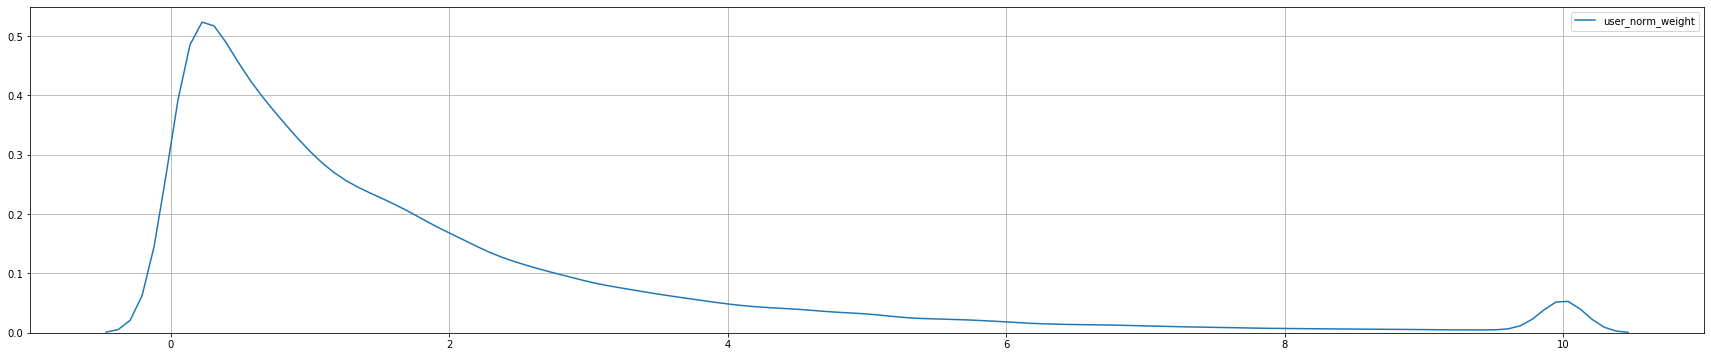

In [0]:
plt.figure(figsize=(30,6))
sns.kdeplot(user_artist['user_norm_weight'])
plt.grid()

In [0]:
skew(user_artist['user_norm_weight']), kurtosis(user_artist['user_norm_weight'])

(2.1043004335525746, 4.690462174920551)

In [0]:
scale = user_artist['user_norm_weight'].min(), user_artist['user_norm_weight'].max()

In [0]:
scale

(7.591112325689083e-05, 10.0)

In [0]:
user_artist.head()

,userID,artistID,weight,minmax_scale,log_weight,log_minmax,max_weight,user_norm_weight
0,2,51,13883,0.393596,9.538420,7.467428,13883,10.000000
1,2,52,11690,0.331418,9.366489,7.332827,13883,8.420370
2,2,53,11351,0.321806,9.337061,7.309788,13883,8.176187
3,2,54,10300,0.292007,9.239899,7.233722,13883,7.419146
4,2,55,8983,0.254666,9.103089,7.126617,13883,6.470503


In [0]:
data_user_norm = Dataset.load_from_df(user_artist.drop(columns=['weight',	'minmax_scale',	'log_weight',	'log_minmax',	'max_weight']), reader= Reader(rating_scale= scale))

In [0]:
eval_user_norm = model_train_evaluate(total_algorithm, data_user_norm, 'user_norm')

SVD
SVDpp


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
Computin

In [0]:
eval_user_norm.groupby('algorithm').mean()

,fit_time,test_mae,test_rmse,test_time
algorithm,,,,
BaselineOnly,0.144629,1.111205,1.752040,0.113187
CoClustering,2.300895,1.161166,1.939818,0.127309
KNNBaseline,0.405911,1.142248,1.845987,1.650930
KNNBasic,0.278796,1.358182,2.061475,1.387456
KNNWithMeans,0.308147,1.181931,1.874657,1.493850
KNNWithZScore,0.396251,1.181334,1.902695,1.610903
NormalPredictor,0.099998,2.040653,2.736585,0.155847
SVD,3.892775,1.090575,1.758149,0.161779
SVDpp,36.940937,1.132951,1.816074,0.793242


# Comparing and Evaluating all model

In [0]:
eval_total = eval_minmax

In [0]:
eval_total = eval_total.append(eval_log_scale, ignore_index=True)

In [0]:
eval_total = eval_total.append(eval_user_norm, ignore_index=True)

In [0]:
eval_total.groupby(['algorithm', 'weight_type']).mean().reset_index().sort_values('test_rmse')

,algorithm,weight_type,fit_time,test_mae,test_rmse,test_time
1,BaselineOnly,minmax_scale,0.132743,0.019778,0.103438,0.107462
7,KNNBaseline,minmax_scale,0.400216,0.020023,0.103608,1.699127
13,KNNWithMeans,minmax_scale,0.308605,0.021789,0.104091,1.472455
25,SVDpp,minmax_scale,36.229042,0.029452,0.105667,0.781669
10,KNNBasic,minmax_scale,0.278551,0.022509,0.106072,1.349892
16,KNNWithZScore,minmax_scale,0.373103,0.020925,0.110885,1.629698
22,SVD,minmax_scale,3.820886,0.043865,0.116026,0.147570
4,CoClustering,minmax_scale,2.103077,0.022677,0.118479,0.080075
19,NormalPredictor,minmax_scale,0.096028,0.059396,0.130394,0.149555
24,SVDpp,log_scaled,36.280566,0.469442,0.637945,0.801269
